### 1. 背景介绍

泰坦尼克号于1909年3月31日在爱尔兰动工建造，1911年5月31日下水，次年4月2日完工试航。她是当时世界上体积最庞大、内部设施最豪华的客运轮船，有“永不沉没”的美誉。然而讽刺的是，泰坦尼克号首航便遭遇厄运：1912年4月10日她从英国南安普顿出发，途径法国瑟堡和爱尔兰昆士敦，驶向美国纽约。在14日晚23时40分左右，泰坦尼克号与一座冰山相撞，导致船体裂缝进水。次日凌晨2时20分左右，泰坦尼克号断为两截后沉入大西洋，其搭载的2224名船员及乘客，在本次海难中逾1500人丧生。

在学习机器学习相关项目时，Titanic生存率预测项目也通常是入门练习的经典案例。Kaggle平台为我们提供了一个竞赛案例“Titanic: Machine Learning from Disaster”，在该案例中，**我们将探究什么样的人在此次海难中幸存的几率更高，并通过构建预测模型来预测乘客生存率**。

本文通过数据可视化理解数据，并利用**特征工程**等方法挖掘更多有价值的特征，然后利用**同组效应**找出共性较强的群体并对其数据进行修正，在选择模型时分别比较了Gradient Boosting Classifier、Logistic Regression等多种方法，最终利用Gradient Boosting Classifier对乘客的生存率进行预测。

最终，在kaggle上模型的得分为0.82775，328名，排名为约为TOP3%。

### 2. 数据准备

本文数据集是来源于Kaggle平台中“Titanic: Machine Learning from Disaster”竞赛项目，数据字段释义如下：

首先，导入基础包来搭建项目分析的环境，并加载相关数据。

In [1]:
# 导入相关的包
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置警告形式
warnings.filterwarnings('ignore')
# 设置sns样式
sns.set(style='white', context='notebook', palette='muted')

In [2]:
# load dataset
train = pd.read_csv(r"../data/Titanic_data.csv")
test = pd.read_csv(r"../data/Titanic_test.csv")

### 3. 理解数据

#### 3.1 查看数据的整体情况

1) 查看数据量及数据特征，理解特征含义

In [3]:
# 分别查看训练数据集和预测数据集数据
print("训练集数据大小: ", train.shape)
print("预测集数据大小: ", test.shape)

训练集数据大小:  (891, 12)
预测集数据大小:  (418, 11)


该数据集共1309条数据，其中训练数据891条，预测数据418条；训练数据比预测数据多了一列：即标签(label)-"Survived"。

2）记录数据异常值、缺失值情况，方便下一步进行数据预处理。

In [4]:
# 将训练数据集和预测数据集进行合并，通常情况下，训练集和预测集会进行相同的特征处理

full_data = train.append(test, ignore_index=True)

In [5]:
# 数据框描述
full_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


这里未看出有明显的异常值，可以看出有些特征含缺失值

In [6]:
# 查看各特征的缺失值情况和数据类型
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


上述信息中可以看出Age、Cabin、Embarked、Fare特征含缺失值，Cabin甚至缺少了近3/4的数据；Survived是我们要预测的目标

#### 3.2 通过可视化的方法查看各特征与标签之间的关系

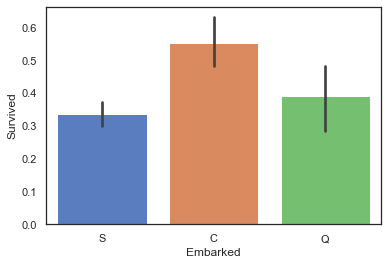

In [7]:
# Embarked and Survived
sns.barplot(x="Embarked", y="Survived", data=train)

C港口登船的乘客生存率较高，位于法国的港口

In [8]:
# 计算不同类型的embarked乘客的生存率
train.groupby(["Embarked"]).Survived.value_counts(normalize=True)

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: Survived, dtype: float64

法国登船乘客生存率较高原因可能与其头等舱乘客比例较高有关，因此继续查看不同登船地点乘客各舱位乘客数量情况。

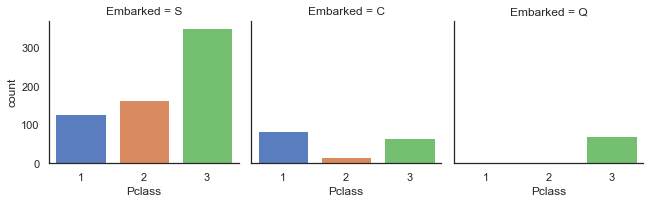

In [9]:
#法国登船乘客生存率较高原因可能与其头等舱乘客比例较高有关
sns.factorplot('Pclass',col='Embarked',data=train,kind='count',size=3)

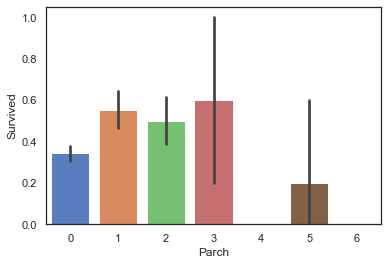

In [10]:
# Parch与Survived
sns.barplot(x='Parch', y='Survived', data=train)

#### 当与乘客同行的父母及子女的数量为1~3时，生存率较高

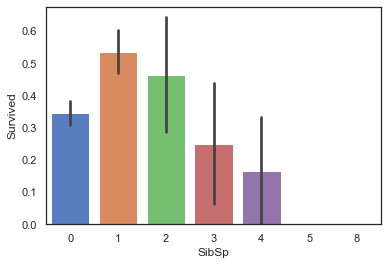

In [11]:
# SibSp与Survived
sns.barplot(x='SibSp', y='Survived', data=train)

#### 提示当与乘客同行的同辈亲属数量在0~2时生存率较高

思考：Parch与SibSp可不可以合并观察，统一算作乘客亲属？

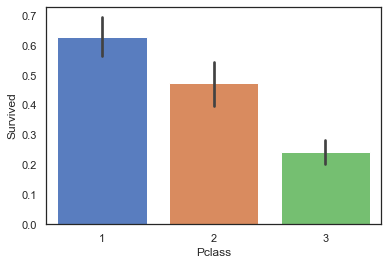

In [12]:
# Pclass与Survived
sns.barplot(x="Pclass", y="Survived", data=train)

#### 客舱等级越高，生存率越高

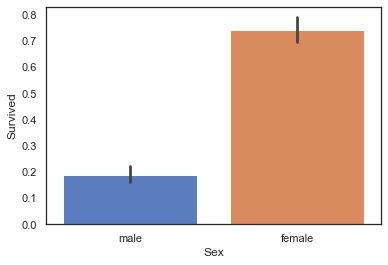

In [13]:
# Sex与Survived
sns.barplot(x="Sex", y="Survived", data=train)

#### 女性的生存率明显高于男性。很好理解这与当时女性和孩子优先的救援策略有关

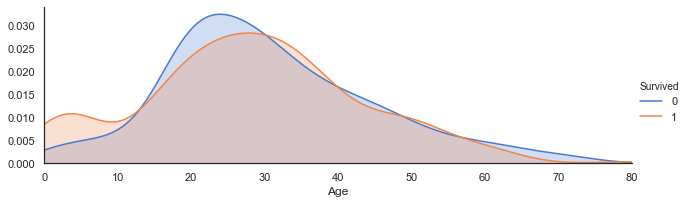

In [14]:
# Age与Survived
## 创建坐标轴
ageFacet = sns.FacetGrid(train, hue="Survived", aspect=3)
ageFacet.map(sns.kdeplot, 'Age', shade=True)
ageFacet.set(xlim=(0, train["Age"].max()))
ageFacet.add_legend()

#### 当乘客年龄段在0-10岁间时生存率会较高

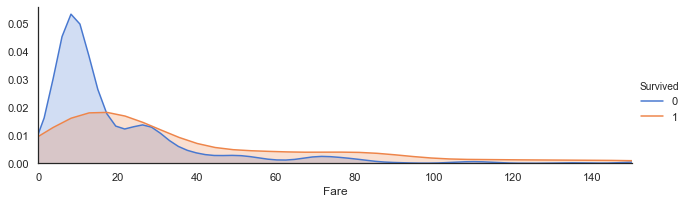

In [15]:
# Fare and Survived

#创建坐标轴
ageFacet=sns.FacetGrid(train,hue='Survived',aspect=3)
ageFacet.map(sns.kdeplot,'Fare',shade=True)
ageFacet.set(xlim=(0,150))
ageFacet.add_legend()

#### 当票价低于18左右时乘客生存率较低，票价越高生存率一般越高

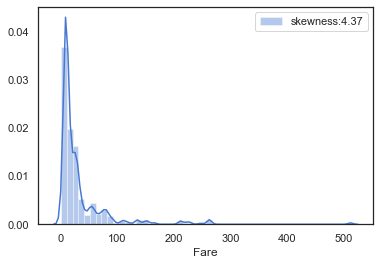

In [16]:
# 查看票价的分布特征
farePlot=sns.distplot(full_data['Fare'][full_data['Fare'].notnull()],label='skewness:%.2f'%(full_data['Fare'].skew()))
farePlot.legend(loc='best')

fare的分布呈左偏的形态，其偏度skewness=4.37较大，说明数据偏移平均值较多，因此我们需要对数据进行对数化处理，防止数据权重分布不均匀。

In [17]:
#对数化处理fare值
# full_data['Fare']=full_data['Fare'].map(lambda x: np.log(x) if x>0 else 0)
# 这里先不处理，否则后续缺失值处理会比较麻烦

### 4. 数据预处理

数据预处理主要包括以下四个方面内容：

- 数据清洗（缺失值以及异常值的处理）
- 特征工程（基于对现有数据特征的理解构造的新特征，以挖掘数据的更多特点）
- 同组识别（找出具有明显同组效应且违背整体规律的数据，对其数据进行修正）
- 筛选子集（对数据进行降维，选择子集）

#### 4.1 数据清洗

对数据的缺失值、异常值进行处理，便于对数据进一步分析。本数据集有四个字段的数据存在缺失情况，即Cabin/Embarked/Fare/Age，未发现数据存在明显异常情况。其中Age字段缺失较多且为连续型数值，将在进行**4.2特征工程**挖取更多特征后再填充缺失值。

In [18]:
# Cabin缺失值填充

#对Cabin缺失值进行处理，利用U（Unknown）填充缺失值
full_data["Cabin"] = full_data["Cabin"].fillna("U")
full_data["Cabin"].head()

0       U
1     C85
2       U
3    C123
4       U
Name: Cabin, dtype: object

In [19]:
# 填充Embarked

#对Embarked缺失值进行处理，查看缺失值情况
full_data[full_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [20]:
# 查看Embarked数据分布情况，可知在英国南安普顿登船可能性最大，因此以此填充缺失值。
full_data["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [21]:
full_data["Embarked"] = full_data["Embarked"].fillna("S")

In [22]:
# 填充Fare，该乘客乘坐3等舱，登船港口为法国，舱位未知
full_data[full_data["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,U,S


In [23]:
# 利用3等舱，登船港口为法国，舱位未知旅客的平均票价来填充缺失值。
full_data['Fare']=full_data['Fare'].fillna(full_data[(full_data['Pclass']==3)&(full_data['Embarked']=='C')&(full_data['Cabin']=='U')]['Fare'].mean())

In [24]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


#### 4.2 特征工程

在理解原数据特征的基础上，特征工程通过对原有数据进行整合处理，得到新特征以反映数据更多信息。

##### Name中的头衔信息

旅客姓名数据中包含头衔信息，不同头衔也可以反映旅客的身份，而不同身份的旅客其生存率有可能会出现较大差异。因此我们通过Name特征提取旅客头衔Title信息，并分析Title与Survived之间的关系。

In [25]:
# 构造新特征Title
full_data["Title"] = full_data["Name"].map(lambda x: x.split(",")[1].split(".")[0].strip())

**注意上面代码中的strip()函数，要不后面会有个大坑**

In [26]:
full_data["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Jonkheer          1
Don               1
Dona              1
Lady              1
the Countess      1
Sir               1
Capt              1
Mme               1
Name: Title, dtype: int64

In [27]:
#将title信息进行整合
# 不知道有没有更简单的方法~~~~
TitleDict={}
TitleDict['Mr']='Mr'
TitleDict['Mlle']='Miss'
TitleDict['Miss']='Miss'
TitleDict['Master']='Master'
TitleDict['Jonkheer']='Master'
TitleDict['Mme']='Mrs'
TitleDict['Ms']='Mrs'
TitleDict['Mrs']='Mrs'
TitleDict['Don']='Royalty'
TitleDict['Sir']='Royalty'
TitleDict['the Countess']='Royalty'
TitleDict['Dona']='Royalty'
TitleDict['Lady']='Royalty'
TitleDict['Capt']='Officer'
TitleDict['Col']='Officer'
TitleDict['Major']='Officer'
TitleDict['Dr']='Officer'
TitleDict['Rev']='Officer'


In [28]:
full_data["Title"] = full_data["Title"].map(TitleDict)

In [29]:
full_data["Title"].value_counts()

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

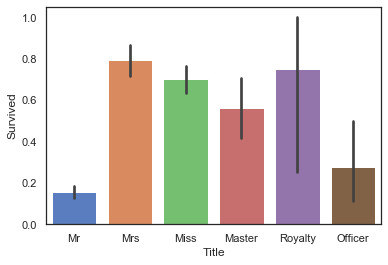

In [30]:
# 可视化新增特征Title与Survived之间的关系
sns.barplot(x="Title", y="Survived", data=full_data)

身份为Mr和Officer的乘客明显生存率较低

##### Parch与SibSp

将Parch及SibSp字段整合得到一名乘客同行家庭成员总人数FamilyNum的字段，再根据家庭成员具体人数的多少得到家庭规模FamilySize这个新字段。

In [31]:
full_data["familyNum"] = full_data.Parch + full_data.SibSp + 1

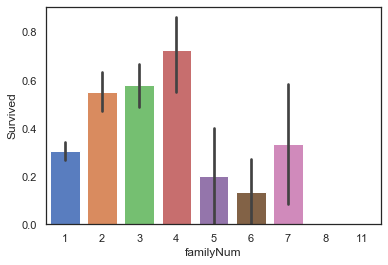

In [32]:
sns.barplot(x='familyNum',y='Survived',data=full_data)

家庭成员人数在2-4人时，乘客的生存率较高，当没有家庭成员同行或家庭成员人数过多时生存率较低。

In [33]:
# 我们按照家庭成员人数多少，将家庭规模分为“小-0、中-1、大-3”三类：
def family_size(familyNum):
    if familyNum == 1:
        return 0
    elif 2 <= familyNum <= 4:
        return 1
    else:
        return 2
    
full_data["familySize"] = full_data['familyNum'].map(family_size)

In [34]:
full_data["familySize"].value_counts()

0    790
1    437
2     82
Name: familySize, dtype: int64

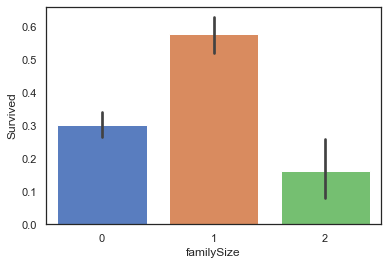

In [35]:
#查看familySize与Survived
sns.barplot(data=full_data,x='familySize',y='Survived')

##### Cabin客舱类型信息-Deck

Cabin字段的首字母代表客舱的类型，也反映不同乘客群体的特点，可能也与乘客的生存率相关。

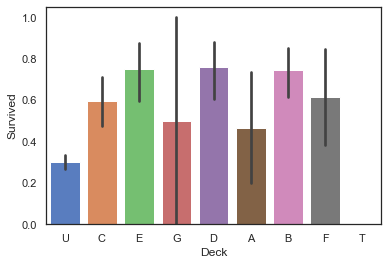

In [36]:
#提取Cabin字段首字母
full_data['Deck']=full_data['Cabin'].map(lambda x:x[0])
#查看不同Deck类型乘客的生存率
sns.barplot(data=full_data,x='Deck',y='Survived')

当乘客的客舱类型为B/D/E时，生存率较高；当客舱类型为U/T时，生存率较低。

#####  共票号乘客数量TickCot及TickGroup

同一票号的乘客数量可能不同，可能也与乘客生存率有关系。

In [37]:
#提取各票号的乘客数量
TickCountDict={}
TickCountDict=full_data['Ticket'].value_counts()
TickCountDict.head()

CA. 2343        11
1601             8
CA 2144          8
S.O.C. 14879     7
347082           7
Name: Ticket, dtype: int64

In [38]:
#将同票号乘客数量数据并入数据集中
full_data['TickCot']=full_data['Ticket'].map(TickCountDict)
full_data['TickCot'].head()

0    1
1    2
2    1
3    2
4    1
Name: TickCot, dtype: int64

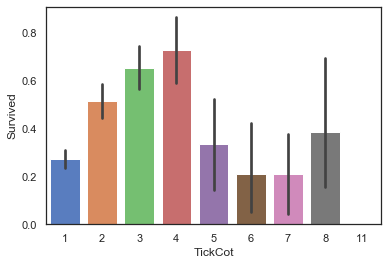

In [39]:
#查看TickCot与Survived之间关系
sns.barplot(data=full_data,x='TickCot',y='Survived')

当TickCot大小适中时，乘客生存率较高。

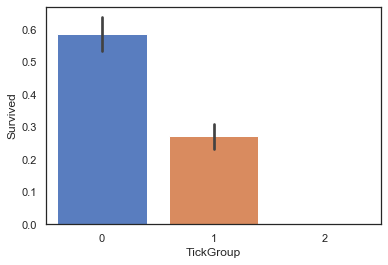

In [40]:
#按照TickCot大小，将TickGroup分为三类。
def TickCountGroup(num):
    if (num>=2)&(num<=4):
        return 0
    elif (num==1)|((num>=5)&(num<=8)):
        return 1
    else :
        return 2
#得到各位乘客TickGroup的类别
full_data['TickGroup']=full_data['TickCot'].map(TickCountGroup)
#查看TickGroup与Survived之间关系
sns.barplot(data=full_data,x='TickGroup',y='Survived')

##### Age缺失值填充-构建随机森林模型预测缺失的数据

查看Age与Parch、Pclass、Sex、SibSp、Title、familyNum、familySize、Deck、TickCot、TickGroup等变量的相关系数大小，筛选出相关性较高的变量构建预测模型。

In [41]:
# 查看缺失值情况
full_data[full_data["Age"].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,familyNum,familySize,Deck,TickCot,TickGroup
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,U,Q,Mr,1,0,U,1,1
17,18,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,U,S,Mr,1,0,U,1,1
19,20,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,U,C,Mrs,1,0,U,1,1
26,27,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,U,C,Mr,1,0,U,1,1
28,29,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,U,Q,Miss,1,0,U,1,1


In [42]:
#筛选数据集
AgePre=full_data[['Age','Parch','Pclass','SibSp','Title','familyNum','TickCot']]
# 进行one-hot编码
AgePre=pd.get_dummies(AgePre)
ParAge=pd.get_dummies(AgePre['Parch'],prefix='Parch')
SibAge=pd.get_dummies(AgePre['SibSp'],prefix='SibSp')
PclAge=pd.get_dummies(AgePre['Pclass'],prefix='Pclass')

# 查看变量间的相关性
AgeCorrDf=AgePre.corr()
AgeCorrDf['Age'].sort_values()

Pclass          -0.408106
Title_Master    -0.385380
Title_Miss      -0.282977
SibSp           -0.243699
familyNum       -0.240229
TickCot         -0.185284
Parch           -0.150917
Title_Royalty    0.057337
Title_Officer    0.166771
Title_Mr         0.183965
Title_Mrs        0.215091
Age              1.000000
Name: Age, dtype: float64

In [43]:
# 拼接数据
AgePre=pd.concat([AgePre,ParAge,SibAge,PclAge],axis=1)
AgePre.head()

,Age,Parch,Pclass,SibSp,familyNum,TickCot,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_1,Pclass_2,Pclass_3
0,22.0,0,3,1,2,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,38.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,26.0,0,3,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,35.0,0,1,1,2,2,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,35.0,0,3,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [44]:
#拆分实验集和预测集
AgeKnown=AgePre[AgePre['Age'].notnull()]
AgeUnKnown=AgePre[AgePre['Age'].isnull()]

#生成实验数据的特征和标签
AgeKnown_X=AgeKnown.drop(['Age'],axis=1)
AgeKnown_y=AgeKnown['Age']
#生成预测数据的特征
AgeUnKnown_X=AgeUnKnown.drop(['Age'],axis=1)

#利用随机森林构建模型
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(random_state=None,n_estimators=500,n_jobs=-1)
rfr.fit(AgeKnown_X,AgeKnown_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [45]:
#预测年龄
AgeUnKnown_y=rfr.predict(AgeUnKnown_X)
#填充预测数据
full_data.loc[full_data['Age'].isnull(),['Age']]=AgeUnKnown_y
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  familyNum    1309 non-null   int64  
 14  familySize   1309 non-null   int64  
 15  Deck         1309 non-null   object 
 16  TickCot      1309 non-null   int64  
 17  TickGroup    1309 non-null   int64  
dtypes: float64(3), int64(8), object(7)
memory usage:

#### 4.3同组识别

虽然通过分析数据已有特征与标签的关系可以构建有效的预测模型，但是部分具有明显共同特征的用户可能与整体模型逻辑并不一致。如果将这部分具有同组效应的用户识别出来并对其数据加以修正，就可以有效提高模型的准确率。在Titancic案例中，我们主要探究相同姓氏的乘客是否存在明显的同组效应。

提取两部分数据，分别查看其“姓氏”是否存在同组效应（因为性别和年龄与乘客生存率关系最为密切，因此用这两个特征作为分类条件）：

12岁以上男性：找出男性中同姓氏均获救的部分；
女性以及年龄在12岁以下儿童：找出女性及儿童中同姓氏均遇难的部分。


In [47]:
#提取乘客的姓氏及相应的乘客数
full_data['Surname']=full_data['Name'].map(lambda x:x.split(',')[0].strip())
SurNameDict={}
SurNameDict=full_data['Surname'].value_counts()
full_data['SurnameNum']=full_data['Surname'].map(SurNameDict)

#将数据分为两组
MaleDf=full_data[(full_data['Sex']=='male')&(full_data['Age']>12)&(full_data['familyNum']>=2)]
FemChildDf=full_data[((full_data['Sex']=='female')|(full_data['Age']<=12))&(full_data['familyNum']>=2)]

In [49]:
#分析男性同组效应
MSurNamDf=MaleDf['Survived'].groupby(MaleDf['Surname']).mean()
MSurNamDf.head()
MSurNamDf.value_counts()

0.0    89
1.0    19
0.5     3
Name: Survived, dtype: int64

大多数同姓氏的男性存在“同生共死”的特点，因此利用该同组效应，我们对生存率为1的姓氏里的男性数据进行修正，提升其预测为“可以幸存”的概率。

In [50]:
#获得生存率为1的姓氏
MSurNamDict={}
MSurNamDict=MSurNamDf[MSurNamDf.values==1].index
MSurNamDict

Index(['Beane', 'Beckwith', 'Bishop', 'Cardeza', 'Chambers', 'Dick',
       'Duff Gordon', 'Frauenthal', 'Frolicher-Stehli', 'Goldenberg',
       'Greenfield', 'Harder', 'Hoyt', 'Kimball', 'Lindqvist', 'McCoy',
       'Nakid', 'Persson', 'Taylor'],
      dtype='object', name='Surname')

In [51]:
#分析女性及儿童同组效应
FCSurNamDf=FemChildDf['Survived'].groupby(FemChildDf['Surname']).mean()
FCSurNamDf.head()
FCSurNamDf.value_counts()

1.000000    115
0.000000     27
0.750000      2
0.333333      1
0.142857      1
Name: Survived, dtype: int64

与男性组特征相似，女性及儿童也存在明显的“同生共死”的特点，因此利用同组效应，对生存率为0的姓氏里的女性及儿童数据进行修正，提升其预测为“并未幸存”的概率。

In [52]:
#获得生存率为0的姓氏
FCSurNamDict={}
FCSurNamDict=FCSurNamDf[FCSurNamDf.values==0].index
FCSurNamDict

Index(['Ahlin', 'Arnold-Franchi', 'Barbara', 'Boulos', 'Bourke', 'Caram',
       'Danbom', 'Ford', 'Goodwin', 'Ilmakangas', 'Johnston', 'Jussila',
       'Lahtinen', 'Lefebre', 'Lobb', 'Palsson', 'Panula', 'Rice', 'Robins',
       'Rosblom', 'Sage', 'Skoog', 'Strom', 'Turpin', 'Van Impe',
       'Vander Planke', 'Zabour'],
      dtype='object', name='Surname')

对数据集中这些姓氏的两组数据数据分别进行修正：

男性数据修正为：1、性别改为女；2、年龄改为5；

女性及儿童数据修正为：1、性别改为男；2、年龄改为60。

In [53]:
#对数据集中这些姓氏的男性数据进行修正：1、性别改为女；2、年龄改为5。
full_data.loc[(full_data['Survived'].isnull())&(full_data['Surname'].isin(MSurNamDict))&(full_data['Sex']=='male'),'Age']=5
full_data.loc[(full_data['Survived'].isnull())&(full_data['Surname'].isin(MSurNamDict))&(full_data['Sex']=='male'),'Sex']='female'

#对数据集中这些姓氏的女性及儿童的数据进行修正：1、性别改为男；2、年龄改为60。
full_data.loc[(full_data['Survived'].isnull())&(full_data['Surname'].isin(FCSurNamDict))&((full_data['Sex']=='female')|(full_data['Age']<=12)),'Age']=60
full_data.loc[(full_data['Survived'].isnull())&(full_data['Surname'].isin(FCSurNamDict))&((full_data['Sex']=='female')|(full_data['Age']<=12)),'Sex']='male'

#### 4.4筛选子集
在对数据进行分析处理的过程中，数据的维度更高了，为提升数据有效性需要对数据进行降维处理。通过找出与乘客生存率“Survived”相关性更高的特征，剔除重复的且相关性较低的特征，从而实现数据降维。

In [64]:
#人工筛选
fullSel=full_data.drop(['Cabin','Name','Ticket','PassengerId','Surname','SurnameNum'],axis=1)

# 查看各特征与标签的相关性
corrDf = fullSel.corr()

In [57]:
corrDf.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'familyNum',
       'familySize', 'TickCot', 'TickGroup'],
      dtype='object')

In [58]:
corrDf.index

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'familyNum',
       'familySize', 'TickCot', 'TickGroup'],
      dtype='object')

In [59]:
corrDf["Survived"].sort_values()

Pclass       -0.338481
TickGroup    -0.319278
Age          -0.059252
SibSp        -0.035322
familyNum     0.016639
TickCot       0.064962
Parch         0.081629
familySize    0.108631
Fare          0.257307
Survived      1.000000
Name: Survived, dtype: float64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

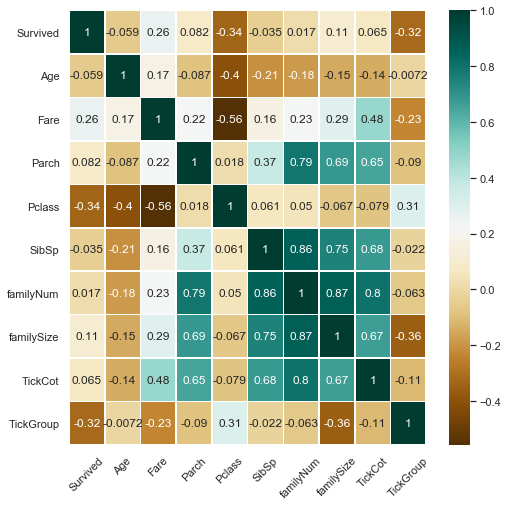

In [60]:
# 热力图，查看Survived与其他特征间的相关性大小
plt.figure(figsize=(8,8))
sns.heatmap(fullSel[['Survived','Age','Embarked','Fare','Parch','Pclass',
                    'Sex','SibSp','Title','familyNum','familySize','Deck',
                     'TickCot','TickGroup']].corr(),cmap='BrBG',annot=True,
           linewidths=.5)
plt.xticks(rotation=45)

In [65]:
fullSel=fullSel.drop(['familyNum','SibSp','TickCot','Parch'],axis=1)

In [66]:
#one-hot编码
fullSel=pd.get_dummies(fullSel)
PclassDf=pd.get_dummies(full_data['Pclass'],prefix='Pclass')
TickGroupDf=pd.get_dummies(full_data['TickGroup'],prefix='TickGroup')
familySizeDf=pd.get_dummies(full_data['familySize'],prefix='familySize')

fullSel=pd.concat([fullSel,PclassDf,TickGroupDf,familySizeDf],axis=1)

In [67]:
fullSel.head()

,Survived,Pclass,Age,Fare,familySize,TickGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_U,Pclass_1,Pclass_2,Pclass_3,TickGroup_0,TickGroup_1,TickGroup_2,familySize_0,familySize_1,familySize_2
0,0.0,3,22.0,7.2500,1,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
1,1.0,1,38.0,71.2833,1,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,1.0,3,26.0,7.9250,0,1,1,0,0,0,...,1,0,0,1,0,1,0,1,0,0
3,1.0,1,35.0,53.1000,1,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0.0,3,35.0,8.0500,0,1,0,1,0,0,...,1,0,0,1,0,1,0,1,0,0


### 5.构建模型

本文先比较了SVC/Decision Tree/Gradient Boosting/Neural network/KNN/Logistic Regression等多种机器学习算法的结果，并对表现较好的Gradient Boosting及Logistic Regression做进一步的对比，最终选择Gradient Boosting对乘客生存率进行预测。

#### 5.1 模型选择

主要考虑使用以下常用的机器学习算法进行比较
- SVC
- Decision Tree
- Extra Trees
- Gradient Boosting
- Random Forest
- KNN
- Logistic Regression
- Linear Discriminant Analysis

In [68]:
# 拆分训练数据和预测数据
experData = fullSel[fullSel["Survived"].notnull()]
preData = fullSel[fullSel["Survived"].isnull()]

In [69]:
experData_X = experData.drop('Survived', axis=1)
experData_y = experData["Survived"]

preData_X = preData.drop("Survived", axis=1)

In [70]:
experData_X.shape

(891, 34)

In [71]:
preData_X.shape

(418, 34)

In [72]:
# 导入机器学习算法库
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [73]:
#设置kfold，交叉采样法拆分数据集
kfold=StratifiedKFold(n_splits=10)

In [74]:
#汇总不同模型算法
classifiers=[]
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

In [75]:
#不同机器学习交叉验证结果汇总
cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,experData_X,experData_y,
                                      scoring='accuracy',cv=kfold,n_jobs=-1))

In [76]:
cv_results

[array([0.61111111, 0.58426966, 0.69662921, 0.74157303, 0.68539326,
        0.68539326, 0.69662921, 0.68539326, 0.69662921, 0.6741573 ]),
 array([0.71111111, 0.80898876, 0.6741573 , 0.82022472, 0.78651685,
        0.7752809 , 0.84269663, 0.73033708, 0.83146067, 0.80898876]),
 array([0.75555556, 0.84269663, 0.74157303, 0.83146067, 0.85393258,
        0.83146067, 0.82022472, 0.7752809 , 0.85393258, 0.84269663]),
 array([0.75555556, 0.86516854, 0.71910112, 0.79775281, 0.84269663,
        0.82022472, 0.82022472, 0.74157303, 0.80898876, 0.84269663]),
 array([0.81111111, 0.85393258, 0.76404494, 0.88764045, 0.88764045,
        0.82022472, 0.84269663, 0.79775281, 0.87640449, 0.82022472]),
 array([0.73333333, 0.73033708, 0.69662921, 0.74157303, 0.74157303,
        0.70786517, 0.76404494, 0.71910112, 0.68539326, 0.7752809 ]),
 array([0.81111111, 0.85393258, 0.7752809 , 0.88764045, 0.82022472,
        0.82022472, 0.84269663, 0.83146067, 0.87640449, 0.84269663]),
 array([0.78888889, 0.85393258, 0.

In [77]:
#求出模型得分的均值和标准差
cv_means=[]
cv_std=[]
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
#汇总数据
cvResDf=pd.DataFrame({'cv_mean':cv_means,
                     'cv_std':cv_std,
                     'algorithm':['SVC','DecisionTreeCla','RandomForestCla','ExtraTreesCla',
                                  'GradientBoostingCla','KNN','LR','LinearDiscrimiAna']})

cvResDf

,cv_mean,cv_std,algorithm
0,0.675718,0.042975,SVC
1,0.778976,0.053242,DecisionTreeCla
2,0.814881,0.039544,RandomForestCla
3,0.801398,0.045509,ExtraTreesCla
4,0.836167,0.038845,GradientBoostingCla
5,0.729513,0.026830,KNN
6,0.836167,0.030879,LR
7,0.826080,0.033532,LinearDiscrimiAna


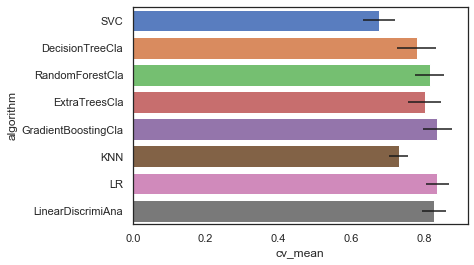

In [78]:
sns.barplot(data=cvResDf,x='cv_mean',y='algorithm',**{'xerr':cv_std})

LR以及GradientBoostingCla模型在该问题中表现较好。

综合以上模型表现，考虑选择GradientBoostingCla、LR两种模型进一步对比。

分别建立GradientBoostingClassifier以及LogisticRegression模型，并进行模型调优。

In [79]:
#GradientBoostingClassifier模型
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss':["deviance"],
    'n_estimators': [100, 200, 300],
    'learning_rate':[0.1, 0.05, 0.01],
    'max_depth': [4, 8],
    'min_samples_leaf': [100,150],
    'max_features': [0.3, 0.1]
}

modelgsGBC = GridSearchCV(GBC, param_grid=gb_param_grid,
                         cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
modelgsGBC.fit(experData_X, experData_y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   47.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=...
                                                  subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1,
   

In [80]:
#LogisticRegression模型
modelLR=LogisticRegression()
LR_param_grid = {'C' : [1,2,3],
                'penalty':['l1','l2']}
modelgsLR = GridSearchCV(modelLR,param_grid = LR_param_grid, cv=kfold, 
                                     scoring="accuracy", n_jobs= -1, verbose = 1)
modelgsLR.fit(experData_X,experData_y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 2, 3], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [81]:
# 查看模型准确度
#modelgsGBC模型
print('modelgsGBC模型得分为：%.3f'%modelgsGBC.best_score_)
#modelgsLR模型
print('modelgsLR模型得分为：%.3f'%modelgsLR.best_score_)

modelgsGBC模型得分为：0.845
modelgsLR模型得分为：0.836


GBC模型得分（即模型准确性）更高，继续比较其他指标的差异。

In [82]:
# 查看模型ROC曲线
from sklearn.metrics import roc_curve, auc

#求出测试数据模型的预测值
modelgsGBCtestpre_y=modelgsGBC.predict(experData_X).astype(int)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(experData_y, modelgsGBCtestpre_y) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

<Figure size 432x288 with 0 Axes>

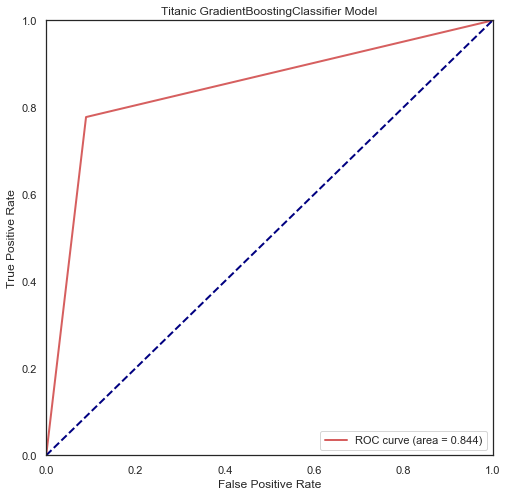

In [84]:
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic GradientBoostingClassifier Model')
plt.legend(loc="lower right")

In [85]:
#求出测试数据模型的预测值
modelgsLRtestpre_y=modelgsLR.predict(experData_X).astype(int)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(experData_y, modelgsLRtestpre_y) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值

<Figure size 432x288 with 0 Axes>

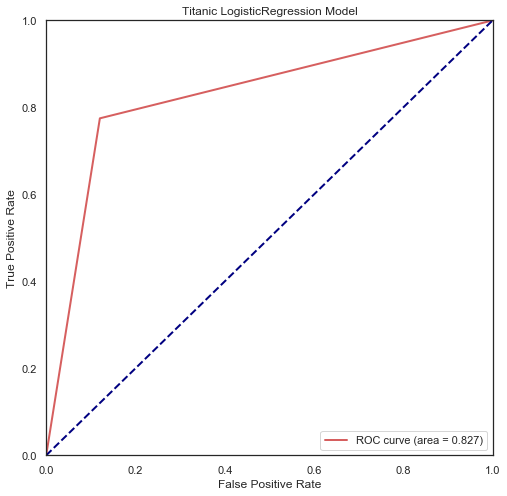

In [86]:
plt.figure()
lw = 2
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Titanic LogisticRegression Model')
plt.legend(loc="lower right")

In [88]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
print('GradientBoostingClassifier模型混淆矩阵为\n',confusion_matrix(experData_y.astype(int).astype(str),modelgsGBCtestpre_y.astype(str)))
print('LinearRegression模型混淆矩阵为\n',confusion_matrix(experData_y.astype(int).astype(str),modelgsLRtestpre_y.astype(str)))

GradientBoostingClassifier模型混淆矩阵为
 [[500  49]
 [ 76 266]]
LinearRegression模型混淆矩阵为
 [[483  66]
 [ 77 265]]


通过混淆矩阵可以看出，GBC模型真正率TPR为914，假正率FPR为0.222，而LR模型真正率TPR为0.871，假正率FPR为0.231，说明GBC找出正例能力很强，同时也不易将负例错判为正例。综合考虑，本项目中将利用GBC方法进行模型预测。

### 6.模型预测
利用模型进行预测，并按规则导出预测结果。

In [89]:
#TitanicGBCmodle
GBCpreData_y=modelgsGBC.predict(preData_X)
GBCpreData_y=GBCpreData_y.astype(int)
#导出预测结果
GBCpreResultDf=pd.DataFrame()
GBCpreResultDf['PassengerId']=full_data['PassengerId'][full_data['Survived'].isnull()]
GBCpreResultDf['Survived']=GBCpreData_y
GBCpreResultDf.head()
#将预测结果导出为csv文件
GBCpreResultDf.to_csv('../data/Titanic_GBSmodle.csv',index=False)

### 7.总结
将结果上传至Kaggle中，最终预测得分为0.82775，排名约TOP3%（本次项目还将LR模型结果上传，得分为0.80861）。

在参与本次kaggle项目过程中，参考学习了很多其他竞赛方案的分析思路以及数据处理技巧，如：考虑同组效应、数据对数化处理、多种模型比较结果优劣等等。在项目过程中，主要从以下三个方面对模型改进来提升准确率：

模型选优：分别选取多种模型进行建模，根据模型评分进行初步比较，最终综合考虑多个性能指标来选择合适的预测模型；
特征挖掘与筛选：通过挖掘新的特征并测试选择不同特征时模型预测的准确性，来选择最终训练模型的特征集合；
数据整容：缺失值的填充方法以及“不合群”数据的处理也直接影响模型的最终预测结果。